# **ANALYSIS OF VISIUM DATA V1_Mouse_Brain_Sagittal_Anterior**

*This notebook is for learning purposes, does not use the most sophisticated code but dives more into understanding the fundamentals of processing these kind of ST data.*

In [ ]:
#Imports and installs

!pip3 install igraph leidenalg scanpy squidpy anndata plotly
!pip install squidpy
# Install system dependencies for igraph
!apt-get install -y libglpk-dev libigraph0-dev

# Then install the Python packages
!pip install pycairo
!pip install igraph
#Imports
import scanpy as sc
import squidpy as sq

import anndata
import os
import tarfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


Data is preprocessed and formatted already.

Contains a sagittal section of the mouse brain.

Dataset: V1_Mouse_Brain_Sagittal_Anterior
Source: Also from 10x Genomics and available through scanpy.datasets.visium_sge.
- also available directly in Scanpy's visium_sge loader.






In [4]:
adata = sc.datasets.visium_sge(sample_id="V1_Mouse_Brain_Sagittal_Anterior")

<ipython-input-4-a08b4d3e87dc>:1: FutureWarning: Use `squidpy.datasets.visium` instead.
  adata = sc.datasets.visium_sge(sample_id="V1_Mouse_Brain_Sagittal_Anterior")


  0%|          | 0.00/8.81M [00:00<?, ?B/s]

  0%|          | 0.00/19.6M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/scanpy/datasets/_datasets.py:555: FutureWarning: Use `squidpy.read.visium` instead.
  return read_visium(sample_dir, source_image_path=source_image_path)
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata.var_names_make_unique()

**Understanding the data structure**

In [6]:
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Notes: Looks similar to sc rna dataset, same foundation: a gene count matrix, with genes as rows and observations (spacial spots) as columns.

n_obs = 2695: Number of observations — in this context, each spot (or barcode) on the spatial transcriptomics slide.

n_vars = 32285: Number of variables — each gene measured per spot.

**.obs: Spot (observation-level) metadata**



**obs: 'in_tissue', 'array_row', 'array_col'**
These are metadata columns for each of the 2695 spots:

**'in_tissue':** Boolean (1/0) indicating whether the spot is within tissue.

**'array_row', 'array_col':** Position of the spot on the capture array — useful for reconstructing the spatial layout.

**.var: Gene (variable-level) metadata**
These are metadata fields for each gene:

'gene_ids': Ensembl gene identifiers or similar.

'feature_types': Usually "Gene Expression" for standard RNA-seq.

'genome': Genome version (e.g. mm10, GRCh38) the genes are mapped to.

** .uns: Unstructured metadata**

'spatial' holds image-related info: histology images, scalefactors, spot coordinates — essential for spatial visualization (squidpy.pl.spatial or sc.pl.spatial).

**.obsm: Multi-dimensional annotations of observations**

'spatial': A matrix of shape (2695, 2) — these are the XY coordinates of each spot on the tissue image.


In [7]:
# Add annotation for mitochondrial genes
adata.var["mt"]=adata.var_names.str.startswith("MT-")

sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace =True)

**FILTERS**

In [8]:
# Filter out spots with less than 200 genes
sc.pp.filter_cells(adata, min_genes = 200)

In [9]:
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

**Note**: Visium != single cells
Although Visium data looks like single-cell data (a gene-by-spot matrix), each spot captures transcripts from a multi-cellular region of the tissue, making it more akin to a series of bulk RNA-seq samples with spatial information.

That difference matters, especially when thinking about how to normalize the data. In spatial transcriptomics, the total number of transcripts in a spot might actually reflect meaningful biology, like differences in tissue density, cellularity, or metabolic activity.

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 314, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text

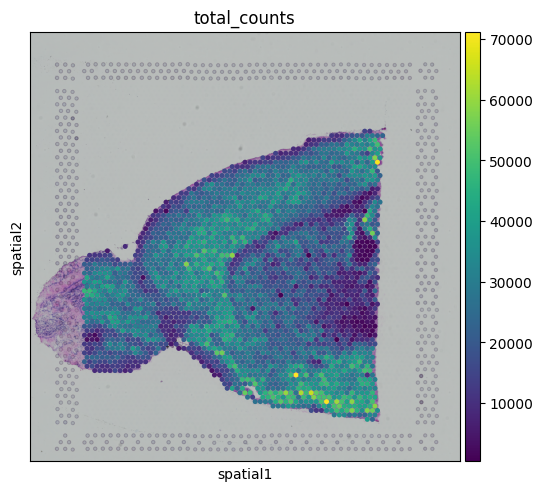

In [10]:
#Visualize the total counts per spot:
import squidpy as sq

sq.pl.spatial_scatter(
    adata,
    color ="total_counts",
    size=1.5
)

**NOTE**                           
Notice that total counts show some spatial structure and aren’t randomly distributed across the tissue. In some cases, these patterns may align with known tissue morphology, hinting at potential biological relevance. This opens up the possibility that total counts may reflect meaningful differences, like local cell density or transcriptional activity.

**Sometimes, the spatial structure you see in total counts may reflect real biology, but other times, it could stem from technical artifacts, such as differences in how well certain regions of the slide captured transcripts. Some areas might just perform better than others in terms of RNA capture, leading to apparent “hotspots” or “cold spots” that aren’t necessarily biologically meaningful.**

In [11]:
# Normalize to 10,000 total counts per spot.
#Keeping things simple and applying standard normaliztion approach.
sc.pp.normalize_total(adata, target_sum=1e4)
#Note- keep in mind that we are treating total counts as technical noise, which may not always be true.
# Log transform the data
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata)

Note: Some studies suggest that combining highly variable genes with spatially variable genes can improve cell type clustering performance (see this preprint for details : https://pmc.ncbi.nlm.nih.gov/articles/PMC11537352/). For simplicity, we’ll stick with standard HVGs here.

# **Dimensionality reduction and visualization**

In [13]:
!pip3 install igraph leidenalg scanpy squidpy anndata plotly


In [14]:
# Run PCA
sc.pp.pca(adata, n_comps=50)

# Calculate neighbors
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Leiden clustering
sc.tl.leiden(adata, resolution=0.8)

# Computing UMAP
sc.tl.umap(adata)

<ipython-input-14-4431874b17ef>:8: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.8)


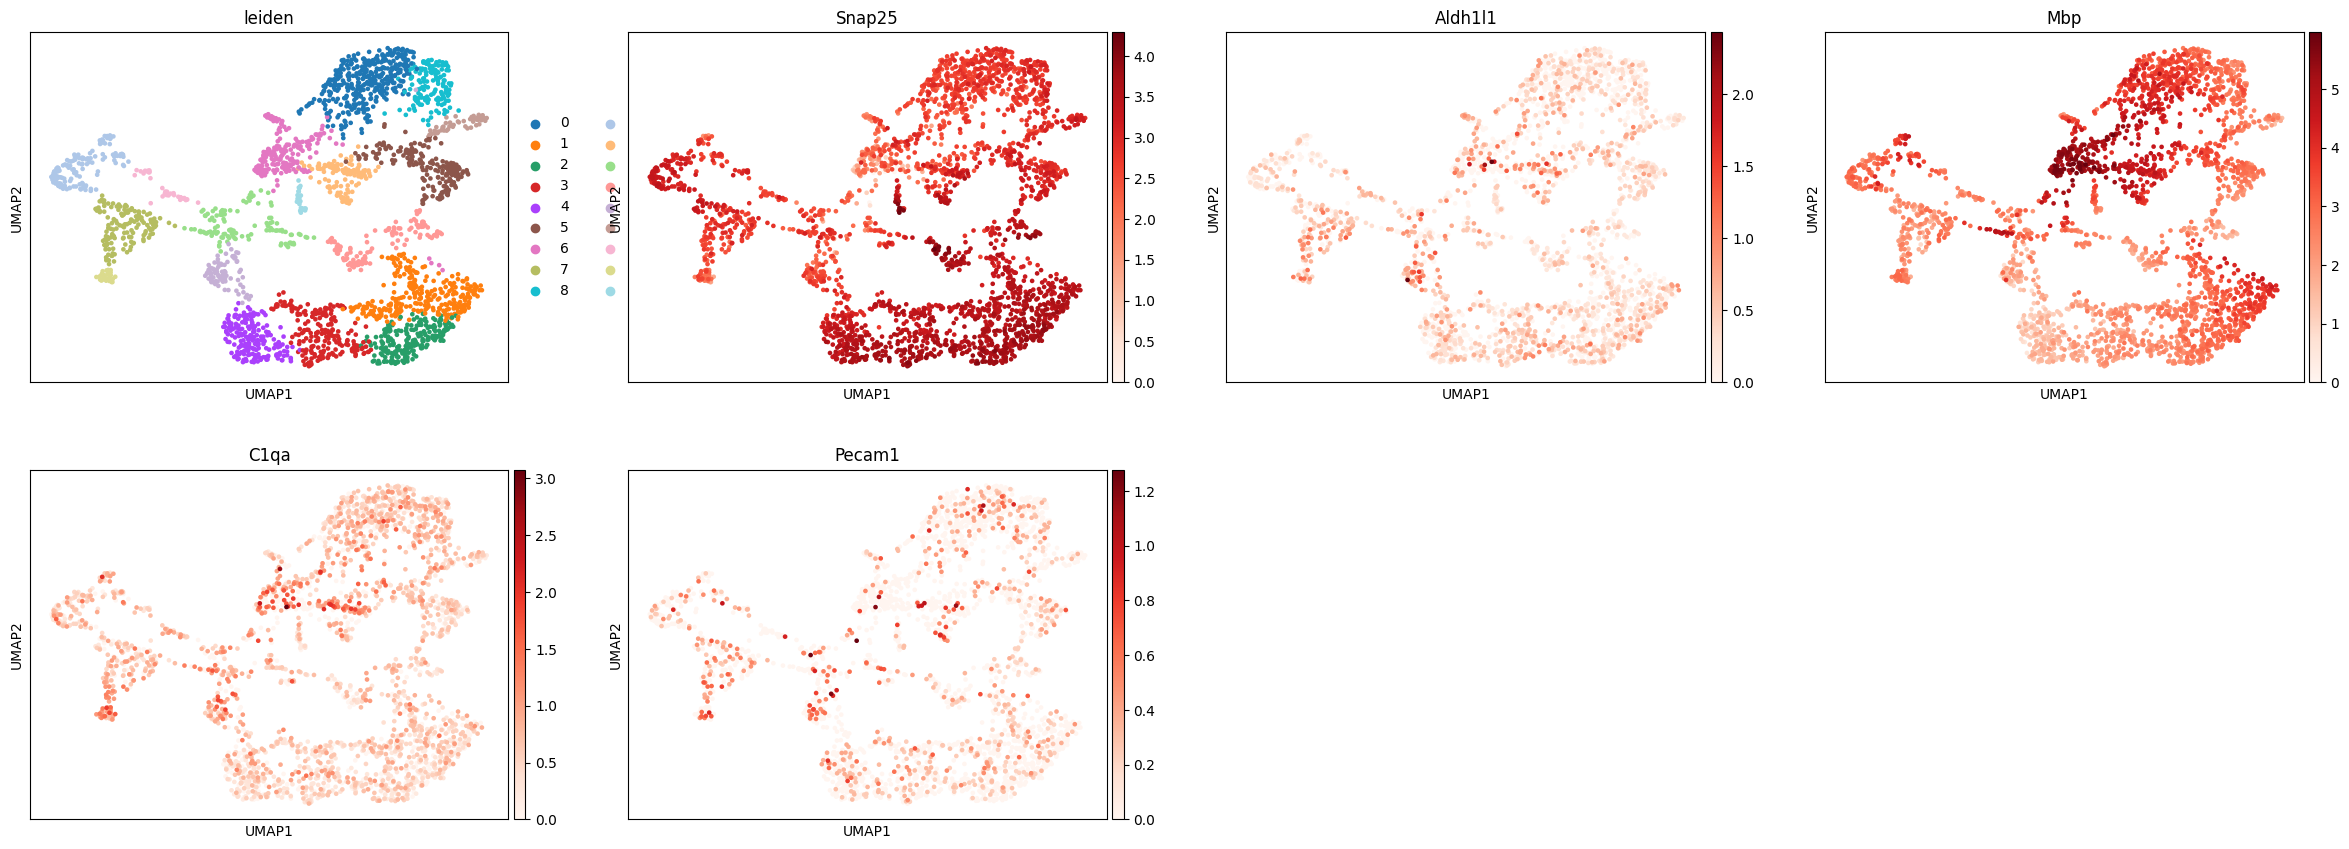

In [16]:
sc.pl.umap(
    adata,
    color=['leiden', 'Snap25', 'Aldh1l1', 'Mbp', 'C1qa', 'Pecam1'],
    cmap='Reds'
)


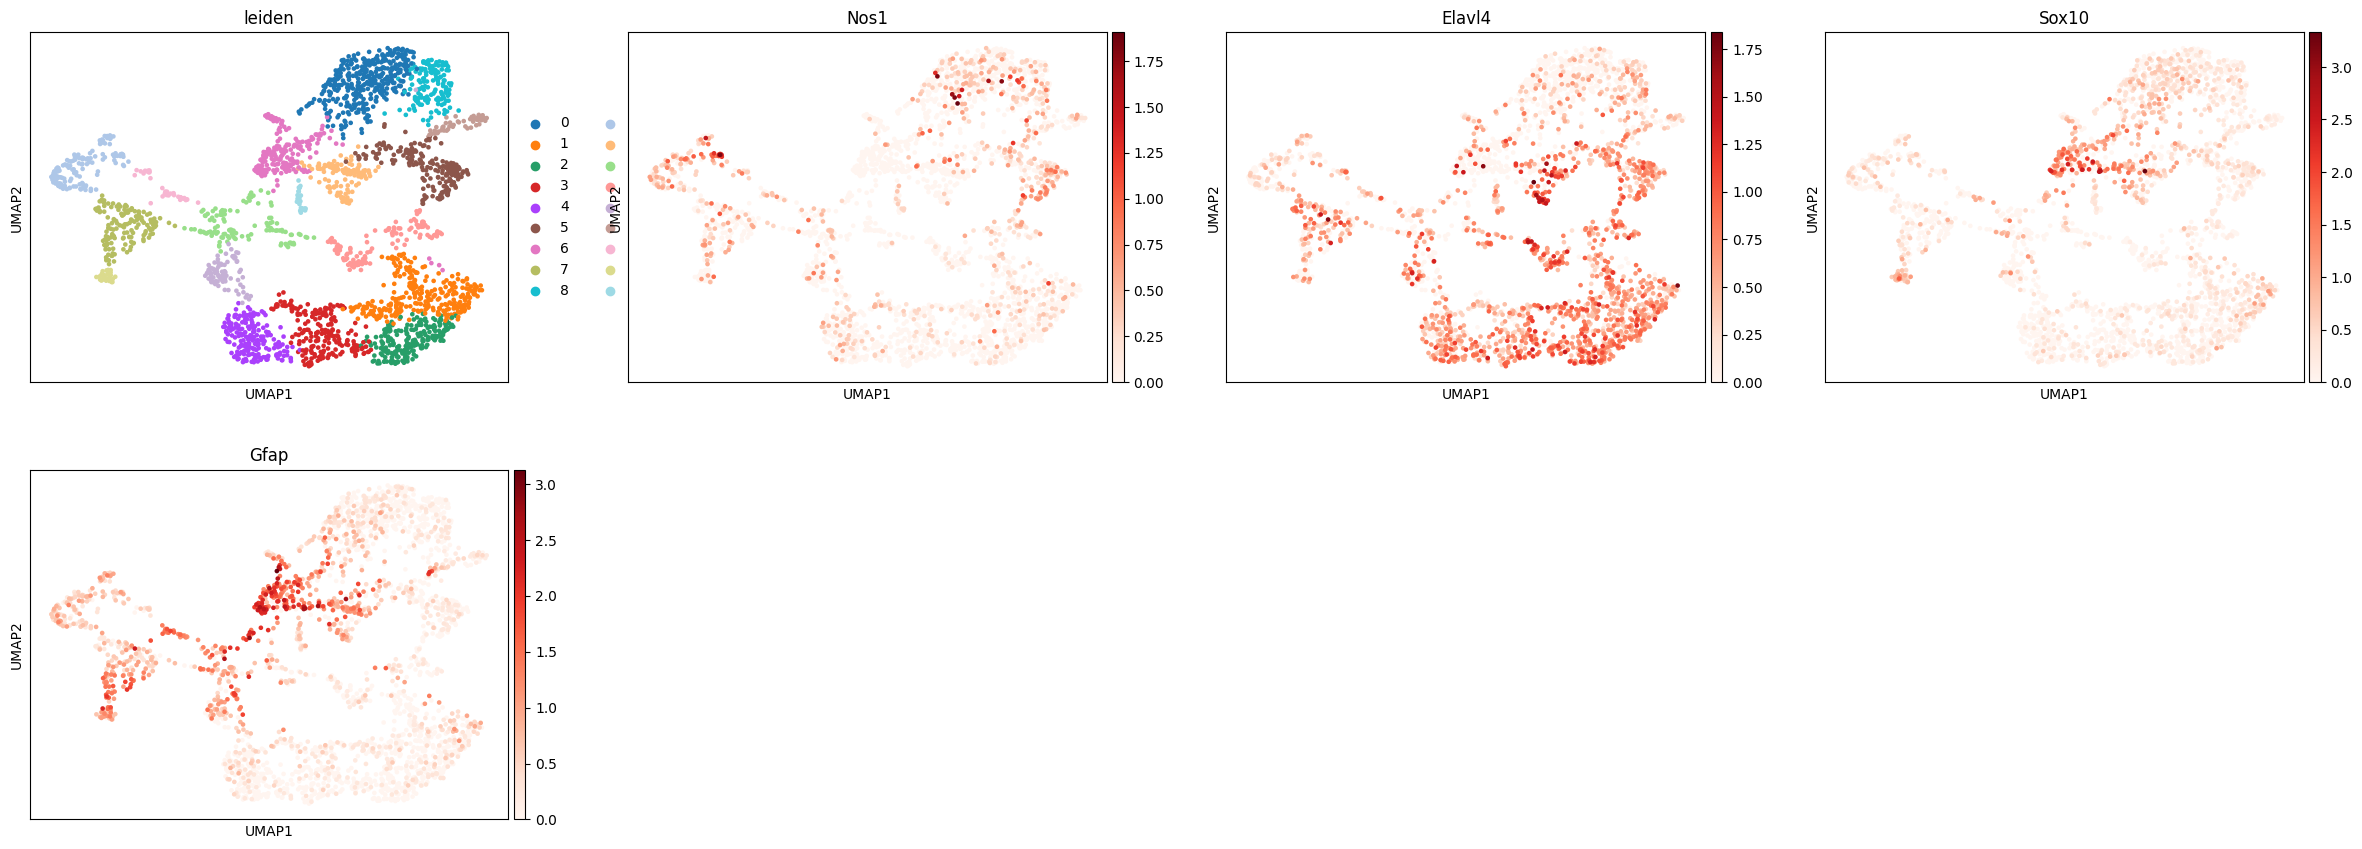

In [18]:
sc.pl.umap(
    adata,
    color=['leiden','Nos1', 'Elavl4', 'Sox10', 'Gfap'],
    cmap='Reds')


Note - Each dot in the UMAP represents a spot, not an individual cell. Unlike in scRNA-seq, we don’t always see crisp clusters corresponding to distinct cell types. Instead, marker gene expression often appears broadly distributed, reflecting the fact that many spots likely contain mixtures of cell types.

# **The Unique Layers of Spatial Transcriptomics**

In [22]:
adata.uns.keys()

odict_keys(['spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors'])

In [21]:
adata.uns['spatial']


{'V1_Mouse_Brain_Sagittal_Anterior': {'images': {'hires': array([[[0.7176471 , 0.7372549 , 0.7294118 ],
           [0.7176471 , 0.7372549 , 0.7294118 ],
           [0.7176471 , 0.73333335, 0.7254902 ],
           ...,
           [0.7254902 , 0.74509805, 0.73333335],
           [0.7254902 , 0.74509805, 0.73333335],
           [0.7254902 , 0.74509805, 0.73333335]],
   
          [[0.7176471 , 0.7372549 , 0.7294118 ],
           [0.7176471 , 0.73333335, 0.7254902 ],
           [0.7176471 , 0.73333335, 0.7254902 ],
           ...,
           [0.7254902 , 0.74509805, 0.73333335],
           [0.7254902 , 0.7411765 , 0.73333335],
           [0.7254902 , 0.7411765 , 0.73333335]],
   
          [[0.7176471 , 0.73333335, 0.7254902 ],
           [0.7176471 , 0.7372549 , 0.7294118 ],
           [0.7176471 , 0.73333335, 0.7294118 ],
           ...,
           [0.7254902 , 0.7411765 , 0.73333335],
           [0.72156864, 0.7411765 , 0.73333335],
           [0.7254902 , 0.74509805, 0.73333335]],
   


In [15]:
img = adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Anterior']['images']['hires']
print(f"Shape: {img.shape}, Type: {type(img)}, Dtype: {img.dtype}")

# First top left pixels
img[:3, :3, :]

Shape: (1998, 2000, 3), Type: <class 'numpy.ndarray'>, Dtype: float32


array([[[0.7176471 , 0.7372549 , 0.7294118 ],
        [0.7176471 , 0.7372549 , 0.7294118 ],
        [0.7176471 , 0.73333335, 0.7254902 ]],

       [[0.7176471 , 0.7372549 , 0.7294118 ],
        [0.7176471 , 0.73333335, 0.7254902 ],
        [0.7176471 , 0.73333335, 0.7254902 ]],

       [[0.7176471 , 0.73333335, 0.7254902 ],
        [0.7176471 , 0.7372549 , 0.7294118 ],
        [0.7176471 , 0.73333335, 0.7294118 ]]], dtype=float32)

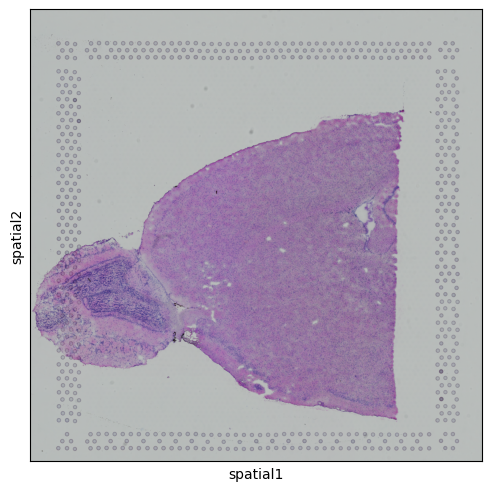

In [26]:
sq.pl.spatial_scatter(adata)


In [28]:
adata.uns['spatial']['V1_Mouse_Brain_Sagittal_Anterior'].keys()


dict_keys(['images', 'scalefactors', 'metadata'])

**Calculating features in image**

In [16]:
img = sq.im.ImageContainer.from_adata(adata)

In [17]:
sq.im.calculate_image_features(
    adata,
    img,
    features="summary",
    key_added="image_features"
)

  0%|          | 0/2695 [00:00<?, ?/s]

This will extract:

Mean intensity (how bright overall)
Standard deviation (how variable)
Quantiles (e.g., top 10% of pixel brightness)

Then you cluster based on those — and you find:
For example:
Cluster A: High intensity, low texture → probably white matter

Cluster B: Low intensity, high texture → densely packed cortex

Cluster C: Irregular intensity → maybe edge of a lesion or transition zone

And when you overlay gene expression, you can check:

Do those clusters show different cell-type markers or functional profiles?
That’s structure-function correlation

| Function                         | Description                                                       |
| -------------------------------- | ----------------------------------------------------------------- |
| `sq.pl.spatial_scatter`          | Spot-based plotting over tissue images                            |
| `sq.gr.spatial_neighbors`        | Builds neighbor graphs **using physical distance** between spots  |
| `sq.gr.nhood_enrichment`         | Tests if certain clusters are spatially co-localized              |
| `sq.im.calculate_image_features` | Extracts features from the tissue image (e.g. texture, intensity) |
| `sq.pl.spatial_autocorr`         | Moran’s I and Geary’s C to find spatially variable genes          |


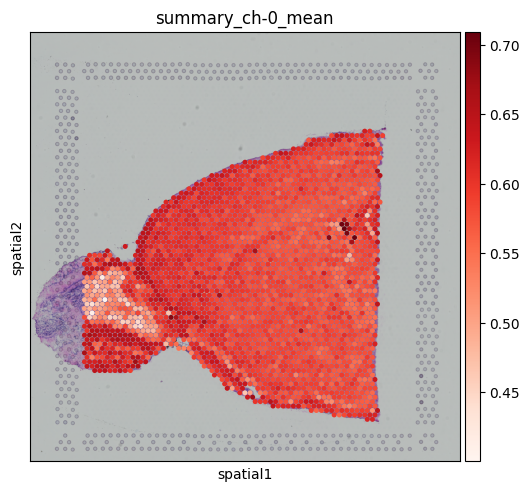

In [18]:
adata.obs["summary_ch-0_mean"] = adata.obsm["image_features"]["summary_ch-0_mean"]
sq.pl.spatial_scatter(
    adata,
    color="summary_ch-0_mean",
    cmap="Reds",
    size=1.5
)

This plot represents the mean pixel intensity from the image under each spot, giving us a rough idea of local brightness across the tissue

**Clustering on image features**


**NOTES**

What biological meaning does image intensity carry?
And why should we care if a spot "looks white" or dark?

the image is typically an H&E-stained histology image:
Hematoxylin stains nuclei (dark blue/purple)
Eosin stains cytoplasm + extracellular matrix (pink)

So, pixel intensity = how much stain is absorbed → which relates to the cellular makeup of that region.

| Visual Intensity          | What it often means biologically                                             |
| ------------------------- | ---------------------------------------------------------------------------- |
| **Dark areas**            | Dense nuclei → many cells, high cellularity (e.g., cortex, tumors)           |
| **Bright (white) areas**  | Few cells, low staining → could be lumen, connective tissue, or white matter |
| **Heterogeneous regions** | Mixed texture = varied cell types or structures                              |



By clustering based on image intensity patterns, you're grouping spots that have similar biological composition, without even looking at gene expression yet.

Since the image features are numerical values (just like gene expression), we can use them for clustering. This allows us to group spots based on similarities in their local tissue appearance.

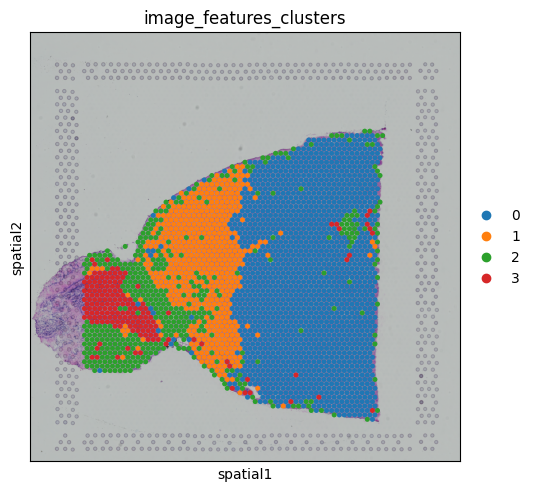

In [19]:
sc.pp.neighbors(adata, use_rep="image_features")
sc.tl.leiden(adata, key_added='image_features_clusters', resolution = 0.1)

#adata.uns.pop('image_features_clusters_colors')
sq.pl.spatial_scatter(
    adata,
    color="image_features_clusters",
    cmap="tab20",
    size=1.5
)

Most features (mean intensity, std, texture contrast) are already scale-limited (e.g., in range 0–255 or normalized by default)

As total number of image features calulated are not very large in number, we don't particularly need to do PCA.

**Spatial Coordinates**

You can access them in adata.obsm



In [20]:
# Extracting spatial coordinates
coords = adata.obsm["spatial"]
print(f"Shape: {coords.shape}, Type: {type(coords)}, Dtype: {coords.dtype}")

# First few coordinates
coords[:3, :]

Shape: (2695, 2), Type: <class 'numpy.ndarray'>, Dtype: int64


array([[8500, 7474],
       [2788, 8552],
       [7950, 3163]])

 **Building a Spatial Neighborhood Graph**

we can build a spatial neighborhood graph. This graph defines which spots are considered neighbors based on their physical proximity on the slide.

In [21]:
sq.gr.spatial_neighbors(adata, coord_type="grid")

The resulting graph is stored in adata.obsp["spatial_connectivities"]



In [41]:
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'summary_ch-0_mean', 'image_features_clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'image_features_clusters', 'image_features_clusters_colors', 'spatial_neighbors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'image_features'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distanc

In [22]:
adata.obsp["spatial_connectivities"].shape


(2695, 2695)

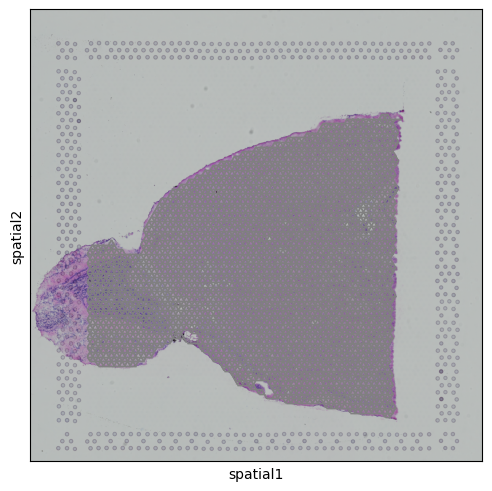

In [23]:
#We can also visualize the graph to see how spots are linked together.

sq.pl.spatial_scatter(adata, connectivity_key="spatial_connectivities")


# **Integrating the Layers of Spatial Transcriptomics**

Gene expression features observed on tissue


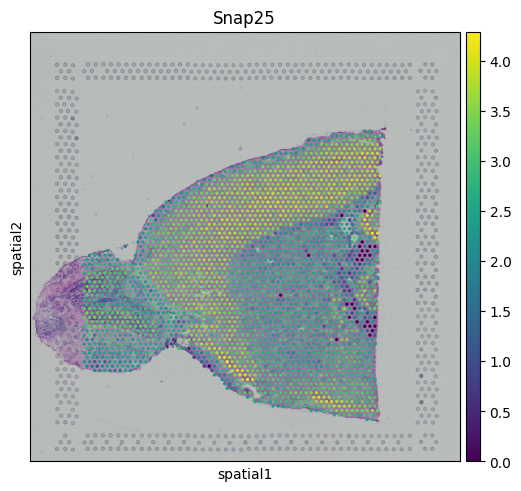

In [46]:
sq.pl.spatial_scatter(adata, color = 'Snap25')


Snap25 is a canonical neuronal marker:

Snap25 is strongly expressed throughout the brain, especially in the cortical and midbrain regions, and almost absent at the tissue edges.

In [50]:
print(adata.var_names[:10])  # Print first 10 gene names
print("th" in adata.var_names)  # Check if 'TH' is in the dataset


Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1'],
      dtype='object')
False


In [51]:
import re
matches = [gene for gene in adata.var_names if re.search("th", gene, re.IGNORECASE)]
print(matches)


['Pth2r', 'Thap4', 'Thsd7b', 'Thnsl1', 'Them7', 'Thbs1', 'Thbd', 'Ythdf1', 'Ythdf3', 'Thbs3', 'Them4', 'Them5', 'Cth', 'Thrap3', 'Ythdf2', 'Themis2', 'Pithd1', 'Mthfr', 'Thap3', 'Dthd1', 'Thegl', 'Ythdc1', 'Mthfd2l', 'Cyth3', 'Thsd7a', 'Thnsl2', 'Mthfd2', 'Thumpd3', 'Pthlh', 'Ethe1', 'Thap8', 'Pth2', 'Cyth2', 'Thrsp', 'Thap12', 'Pth', 'Thumpd1', 'Th', 'Thsd1', 'Thap1', 'Thap11', 'Mthfsd', 'Thyn1', 'Thy1', 'Thsd4', 'Mthfsl', 'Mthfs', 'Pth1r', 'Mthfd1l', 'Themis', 'Theg', 'Thop1', 'Thap2', 'Thoc5', 'Thg1l', 'Thra', 'Tha1', 'Cyth1', 'Mthfd1', 'Thoc3', 'Thbs4', 'Thoc7', 'Thrb', 'Thtpa', 'Cthrc1', 'Them6', 'Cyth4', 'Enthd1', 'Thap7', 'Thpo', 'Thbs2', 'Thoc6', 'Nthl1', 'Themis3', 'Thumpd2', 'Thada', 'Thoc1', 'Ythdc2', 'Fth1', 'Fthl17b', 'Fthl17c', 'Fthl17d', 'Fthl17e', 'Fthl17f', 'Thoc2', 'Fthl17a']


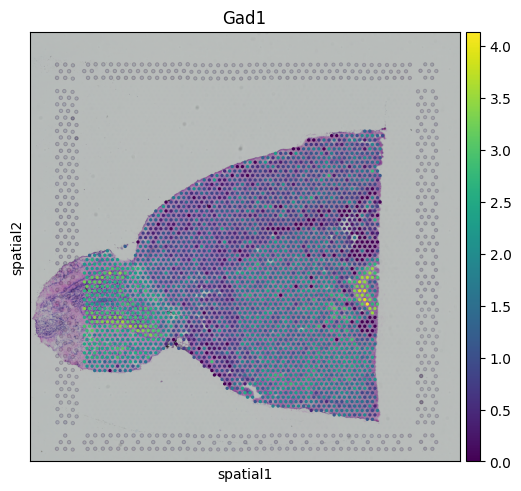

In [55]:
sq.pl.spatial_scatter(adata, color = 'Gad1') #for GABAergic neurons.


# **Spatial Mapping of Gene Expression Clusters**

We can visualize the Leiden clusters computed from the gene expression data directly on the tissue. This allows us to see whether spots that are transcriptionally similar are also spatially close to one another and whether distinct expression programs correspond to specific tissue regions

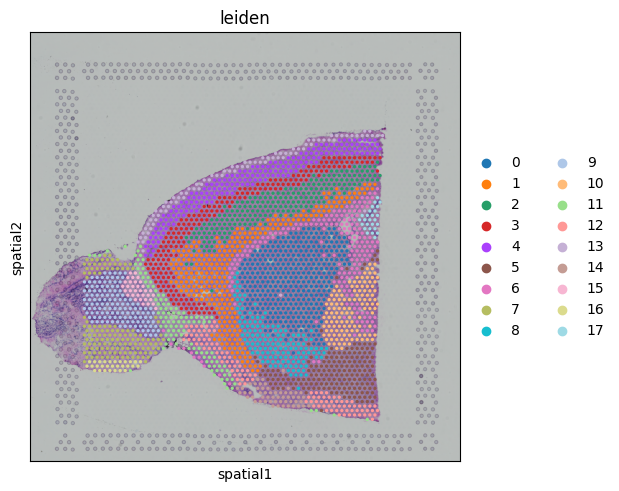

In [24]:
sq.pl.spatial_scatter(adata, color = 'leiden')


We can visualize the Leiden clusters computed from the gene expression data directly on the tissue. This allows us to see whether spots that are transcriptionally similar are also spatially close to one another and whether distinct expression programs correspond to specific tissue regions.

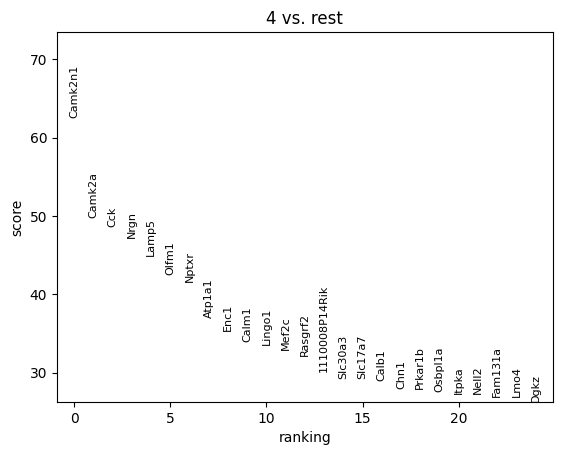

In [28]:
sc.tl.rank_genes_groups(adata, 'leiden')
sc.pl.rank_genes_groups(adata, n_genes=25, groups = ['4'])

| Gene                    | Meaning / Implication                                                                                      |
| ----------------------- | ---------------------------------------------------------------------------------------------------------- |
| **Camk2n1**, **Camk2a** | Found in **excitatory glutamatergic neurons**, but broadly expressed in **upper layers**, esp. L2/3 and L4 |
| **Cck**                 | Expressed in **both excitatory neurons** and **some interneuron types** (e.g. CCK+ interneurons)           |
| **Nrgn**                | Common in **Layer 2/3** neurons and involved in synaptic plasticity                                        |
| **Lamp5**               | Canonical marker for **neurogliaform inhibitory interneurons** (often in L1–L3)                            |


Cluster 4 is likely a mixture of:

Layer 2/3 or Layer 4 excitatory neurons + some Lamp5+ inhibitory interneurons.

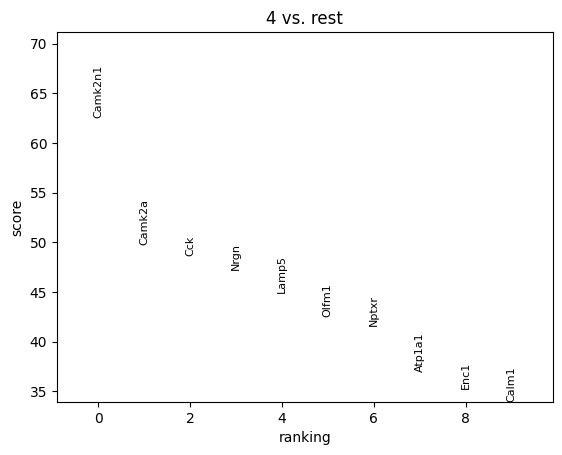

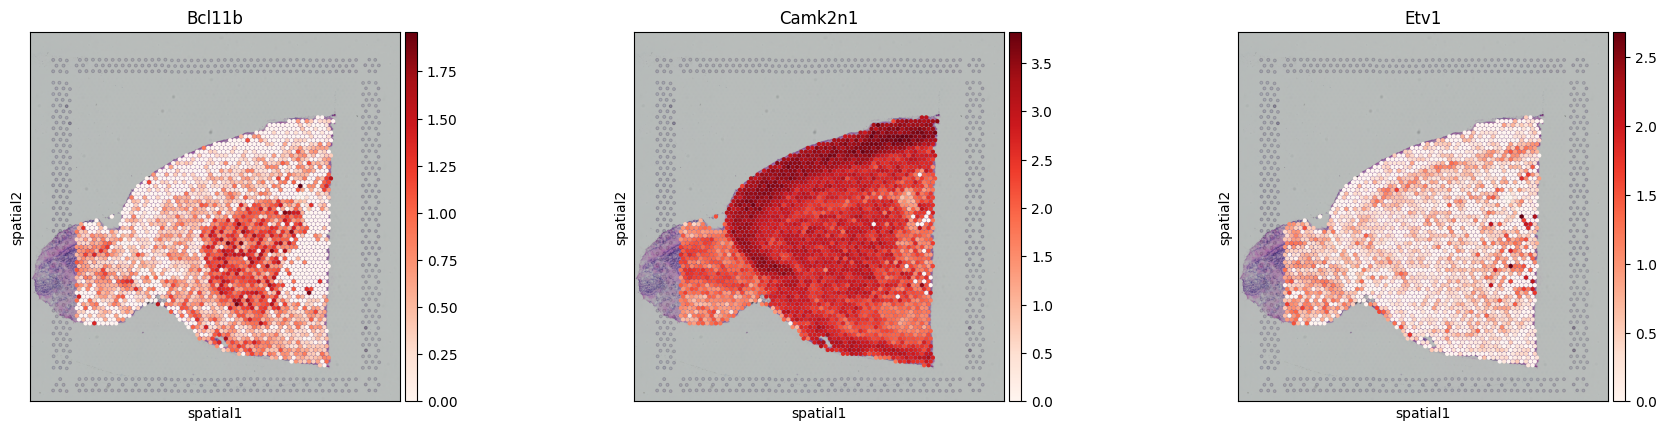

In [32]:
#Cross- Validating the gene ranking and we can see Camk2n1 getting expressed a lot in 4 cluster)
sc.pl.rank_genes_groups(adata, groups=['4'], n_genes=10, sharey=False)
sq.pl.spatial_scatter(adata, color=['Bcl11b', 'Camk2n1', 'Etv1'], size=1.5, cmap='Reds')


**Finding Spatially Variable Genes**


Let's see genes whose expression levels are non-randomly distributed across the tissue.

One way to quantify this is with Moran’s I, a measure of spatial autocorrelation. Genes with high Moran’s I values tend to be expressed in spatially coherent patterns, rather than scattered randomly across spots.

In [34]:
sq.gr.spatial_autocorr(adata, mode="moran")

In [36]:
# Top spatially structured genes
adata.uns["moranI"]["I"].sort_values(ascending=False).head(10)

S100a5     0.911748
Gpr88      0.885629
Penk       0.860315
Cck        0.859777
Ppp1r1b    0.857756
Slc17a7    0.854128
Calb2      0.846652
Pcp4       0.837982
Pde10a     0.837064
Rgs9       0.827577
Name: I, dtype: float64

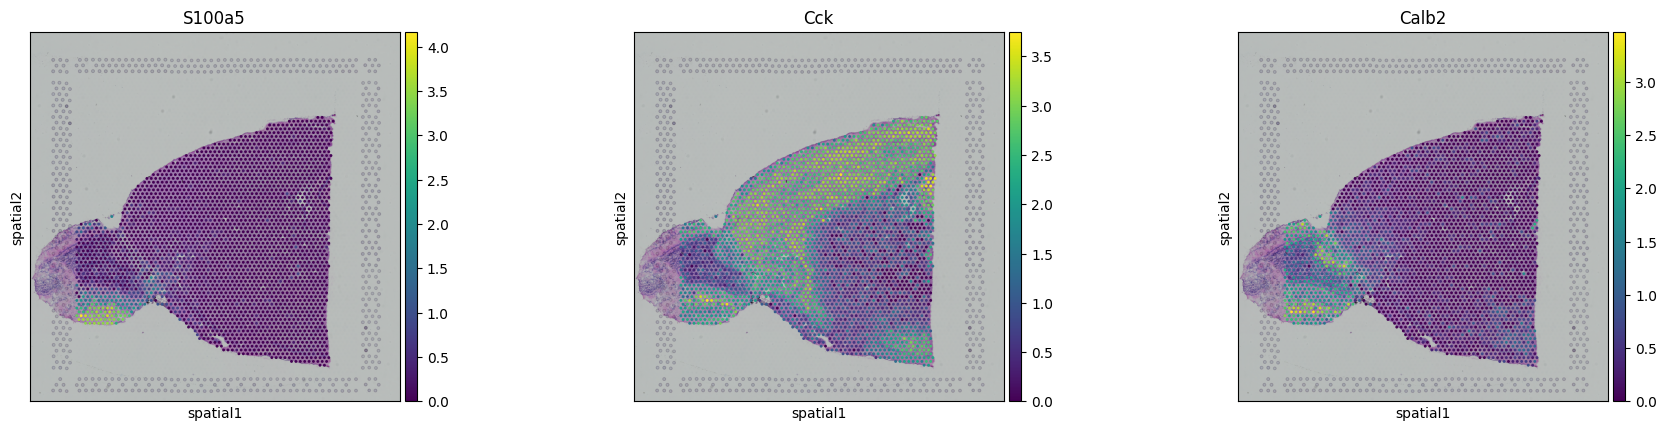

In [38]:
sq.pl.spatial_scatter(adata, color = ['S100a5', 'Cck', 'Calb2'])

#**Segmenting the Tissue into Spatial Domains**

Basically, It’s about dividing the tissue into meaningful regions based on both:

**What the cells are doing (gene expression) and**

**Where they are physically located (spatial coordinates)**

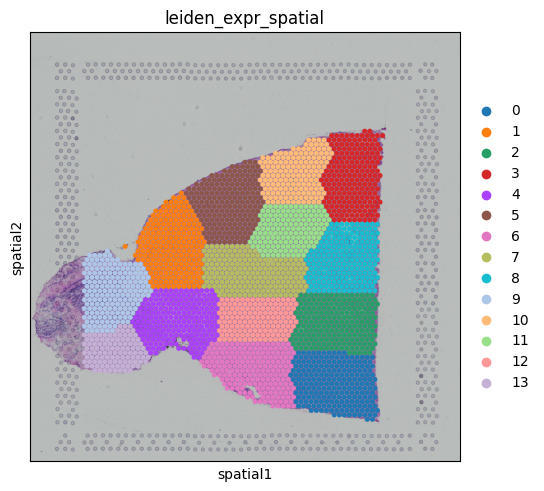

In [40]:
import numpy as np
# Extract PCA and spatial coordinates
X_pca = adata.obsm["X_pca"][:, :10]  # use first 10 PCs
X_spatial = adata.obsm["spatial"]

# Concatenate PCA + spatial into a new matrix
X_combined = np.concatenate([X_pca, X_spatial], axis=1)
adata.obsm["X_expr_space"] = X_combined

# Build neighbor graph and cluster using the combined features
sc.pp.neighbors(adata, use_rep="X_expr_space")
sc.tl.leiden(adata, key_added="leiden_expr_spatial", resolution = 0.5)

# Visualize
sq.pl.spatial_scatter(adata, color="leiden_expr_spatial", size=1.5)

In [41]:
print(X_pca[0])


[ 7.374573   -2.925144   -1.6805515  -3.0845869   4.4383883   1.6350688
  4.385641   -0.74574983 -0.4479843   2.705065  ]


But the spatial coordinates are on a completely different scale:



In [42]:
print(X_spatial[0])


[8500 7474]


Because the spatial coordinates have much larger magnitudes, they dominate the clustering, overpowering the transcriptional signal. The result is clustering that is driven almost entirely by physical location.

To fix thi

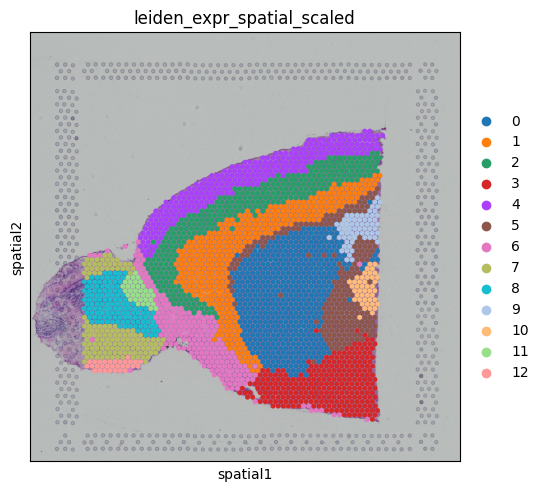

In [52]:
# Scale values
from sklearn.preprocessing import StandardScaler

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

scaler_spatial = StandardScaler()
X_spatial_scaled = scaler_spatial.fit_transform(X_spatial)

# Combine into one matrix
X_combined = np.concatenate([X_pca_scaled, X_spatial_scaled], axis=1)
adata.obsm["X_expr_spatial_scaled"] = X_combined

# Neighbors + clustering
sc.pp.neighbors(adata, use_rep="X_expr_spatial_scaled")
sc.tl.leiden(adata, key_added="leiden_expr_spatial_scaled", resolution = 0.5)

# Visualize
sq.pl.spatial_scatter(adata, color="leiden_expr_spatial_scaled", size=1.5)

We now get regions that reflect a balance of spatial coherence and transcriptional similarity, a much more meaningful segmentation of the tissue

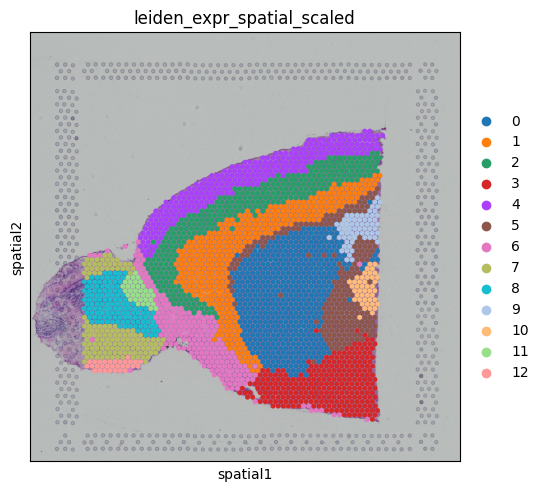

In [51]:
sq.pl.spatial_scatter(adata, color='leiden_expr_spatial_scaled', cmap='tab20', size=1.5)


If we increase the number of PCs: We can see more biological variation to the clustering — potentially detecting finer subtypes, but also possibly increasing noise and splitting clusters that might not be truly distinct.

This tutorial is inspired by a blog on Chatomics (By Tommy Ming):https://divingintogeneticsandgenomics.com/post/python-visium/

by Author: Angel Galvez Merchan

In my version, for practice I have used V1_Mouse_Brain_Sagittal_Anterior instead of V1_Human_Lymph_Node. Hence I have used different markers for identifying cell types as well.

This notebook also contains my personal notes that I found important/helpful while doing it.